In [1]:
import numpy as np
from skimage import io, color, exposure, transform
from skimage.color import rgb2gray
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split  #it came from update scikit learn. https://stackoverflow.com/questions/40704484/importerror-no-module-named-model-selection
import os
import glob
import h5py

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D,Conv1D
from keras.layers.pooling import MaxPooling2D

from keras.layers.convolutional import Convolution2D, MaxPooling2D

from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_first')

from matplotlib import pyplot as plt
#%matplotlib inline

#import keras

NUM_CLASSES = 2
IMG_SIZE = 48
IMG_depth = 3

Using TensorFlow backend.


In [2]:
def preprocess_img(img):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,centre[1]-min_side//2:centre[1]+min_side//2,:]
#    img = rgb2gray(img)

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1)

    return img

def get_class(img_path):
    return int(img_path.split('/')[-2])

In [3]:
imgs = []
labels = []
root_dir = '/media/atif/0820209220208930/unreal_cv_documentation/ignore_from_git/keras_graph_AI/train/'
#path='/home/atif/training_by_several_learning_process/flower_photos/00000/'

#all_img_paths = glob.glob(path+ '5547758_eea9edfd54_n_000.jpg')

all_img_paths = glob.glob(os.path.join(root_dir, '*/*.png')) #I have done the training with .ppm format image. If another type of image will come 
                                                                                    #them .ppm will be changed by that extension
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    try:
        img = preprocess_img(io.imread(img_path))
        label = get_class(img_path)
        imgs.append(img)
        labels.append(label)

        if len(imgs)%1000 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
            #print("get it 2")
    except (IOError, OSError):
        print('missed', img_path)
        pass

X = np.array(imgs, dtype='float32') #Keeping the image as an array
Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]

/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


Processed 1000/2160
Processed 2000/2160


In [4]:
test_imgs=[]
root_test_dir = r'/media/atif/0820209220208930/unreal_cv_documentation/ignore_from_git/keras_graph_AI/test/'
# test_image_dir = glob.glob(os.path.join(root_test_dir, '*/*.png'))
test_image_dir=glob.glob(root_test_dir+ '/*.png')

np.random.shuffle(test_image_dir)
for test_img_path in test_image_dir:
    try:
        img = preprocess_img(io.imread(test_img_path))
#         label = get_class(img_path)
        test_imgs.append(img)
#         labels.append(label)

        if len(test_imgs)%1000 == 0: print("Processed {}/{}".format(len(test_imgs), len(test_image_dir)))
            #print("get it 2")
    except (IOError, OSError):
        print('missed', test_img_path)
        pass

Z = np.array(test_imgs, dtype='float32') #Keeping the image as an array
# Z_label = np.eye(NUM_CLASSES, dtype='uint8')[labels]
print(len(Z))
print(Z.shape)
# plt.show(1,3,0:,0:)
# print(Z.ndim)
# print(Z[0].size)

9
(9, 3, 48, 48)


In [5]:
X = X.reshape(len(imgs),IMG_depth,IMG_SIZE,IMG_SIZE) # write (IMG_SIZE,IMG_SIZE,1 if you want channel last; 1= grayscale;3=RGB)
# plt.imshow(X[0],cmap="gray")
print(X.shape)
print(X.ndim)
print(X[0].shape)

print(X.shape)
print(Y.shape)

(2160, 3, 48, 48)
4
(3, 48, 48)
(2160, 3, 48, 48)
(2160, 2)


In [6]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

model = cnn_model()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 48, 48)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 46, 46)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 23, 23)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 23, 23)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 23, 23)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 21, 21)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 10, 10)        0         
__________

In [8]:
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
epochs = 2
do_train_model=model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,verbose=2,
          #np.resize(img, (-1, <image shape>)
          callbacks=[LearningRateScheduler(lr_schedule),ModelCheckpoint('/media/atif/0820209220208930/unreal_cv_documentation/ignore_from_git/keras_graph_AI/do_train_model.h5', save_best_only=False)])

Train on 1728 samples, validate on 432 samples
Epoch 1/2
 - 50s - loss: 0.6622 - acc: 0.6424 - val_loss: 0.6780 - val_acc: 0.4861
Epoch 2/2
 - 50s - loss: 0.6344 - acc: 0.6725 - val_loss: 0.5443 - val_acc: 0.9630


In [ ]:
# do_train_model.history

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


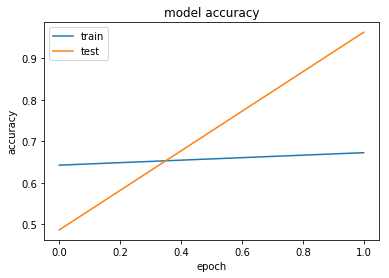

In [9]:
# history = model.fit(X, Y, validation_split=0.33, epochs=1, batch_size=32, verbose=0)
# list all data in history
print(do_train_model.history.keys())
# summarize history for accuracy
plt.plot(do_train_model.history['acc'])
plt.plot(do_train_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


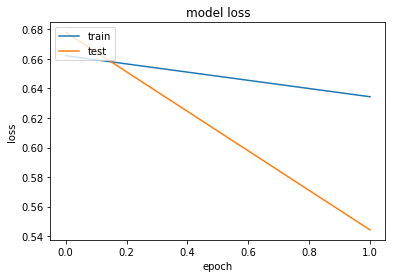

In [10]:
print(do_train_model.history.keys())
# summarize history for accuracy
plt.plot(do_train_model.history['loss'])
plt.plot(do_train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model
model = load_model('/media/atif/0820209220208930/unreal_cv_documentation/ignore_from_git/trained_file_AI/trained_UE4_first.h5')
#for gray scale
def preprocess_img(img):
#     Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]
#     img = rgb2gray(img)

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1)

    return img

import glob

path = r'/media/atif/0820209220208930/unreal_cv_documentation/ignore_from_git/test_image_AI/'

img_path = glob.glob(path+ '/*.png')
for image in img_path:
    X_test=[]
    X_test.append(preprocess_img(io.imread(image)))
    X_test = np.array(X_test)
#     plt.imshow(X_test)
    X_test = X_test.reshape(len(X_test),3,IMG_SIZE,IMG_SIZE)
    
    print("\n",image)
    predicted_class = model.predict_classes(X_test)
    print("predicted class: ",predicted_class)
    
    probability = model.predict_proba(X_test)
    print("probability: ",probability)
    
#     evaluate=model.evaluate(X_test)
#     print("\nEvaluation",evaluate)